In [28]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [14]:
csv_path = 'x_gfild (1).CSV'

In [15]:
df = pd.read_csv(csv_path, delimiter=';')
df

,Uhrzeit,lorry_free,lorry_space,lorry_parked,utilization,utilization_corrected
0,10.06.2022 14:58,14,29,15,"51,72413793","47,5862069"
1,10.06.2022 14:59,14,29,15,"51,72413793","47,5862069"
2,10.06.2022 15:00,13,29,16,"55,17241379","50,75862069"
3,10.06.2022 15:01,14,29,15,"51,72413793","47,5862069"
4,10.06.2022 15:02,14,29,15,"51,72413793","47,5862069"
...,...,...,...,...,...,...
507113,19.06.2023 15:15,26,29,3,"10,34482759","9,517241383"
507114,19.06.2023 15:16,26,29,3,"10,34482759","9,517241383"
507115,19.06.2023 15:17,26,29,3,"10,34482759","9,517241383"
507116,19.06.2023 15:18,26,29,3,"10,34482759","9,517241383"


In [22]:
df.index = pd.to_datetime(df['Uhrzeit'], format='%d.%m.%Y %H:%M')

,Uhrzeit,lorry_free,lorry_space,lorry_parked,utilization,utilization_corrected
Uhrzeit,,,,,,
2023-03-13 21:21:00,13.03.2023 21:21,0,29,29,100,92
2023-03-13 21:21:00,13.03.2023 21:21,0,29,29,100,92
2023-03-13 21:21:00,13.03.2023 21:21,0,29,29,100,92
2023-03-13 21:21:00,13.03.2023 21:21,0,29,29,100,92
2023-03-13 21:22:00,13.03.2023 21:22,0,29,29,100,92
...,...,...,...,...,...,...
2023-06-19 15:15:00,19.06.2023 15:15,26,29,3,"10,34482759","9,517241383"
2023-06-19 15:16:00,19.06.2023 15:16,26,29,3,"10,34482759","9,517241383"
2023-06-19 15:17:00,19.06.2023 15:17,26,29,3,"10,34482759","9,517241383"


In [93]:
df.index

DatetimeIndex(['2022-06-10 14:58:00', '2022-06-10 14:59:00',
               '2022-06-10 15:00:00', '2022-06-10 15:01:00',
               '2022-06-10 15:02:00', '2022-06-10 15:03:00',
               '2022-06-10 15:04:00', '2022-06-10 15:05:00',
               '2022-06-10 15:06:00', '2022-06-10 15:07:00',
               ...
               '2023-06-19 15:10:00', '2023-06-19 15:11:00',
               '2023-06-19 15:12:00', '2023-06-19 15:13:00',
               '2023-06-19 15:14:00', '2023-06-19 15:15:00',
               '2023-06-19 15:16:00', '2023-06-19 15:17:00',
               '2023-06-19 15:18:00', '2023-06-19 15:19:00'],
              dtype='datetime64[ns]', name='Uhrzeit', length=507118, freq=None)

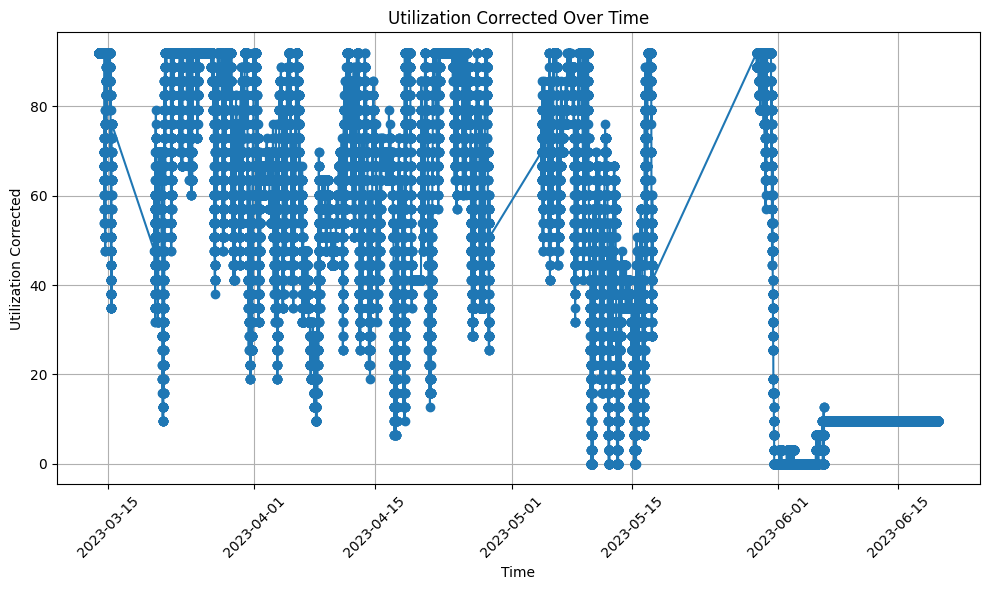

In [39]:
utilization_corrected_data = df['utilization_corrected']
utilization_corrected_data = utilization_corrected_data[400000:]
utilization_corrected_data = utilization_corrected_data.str.replace(',', '.').astype(float)

# Plotten der Daten
plt.figure(figsize=(10, 6))
plt.plot(utilization_corrected_data, marker='o')
plt.title('Utilization Corrected Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization Corrected')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [44]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(utilization_corrected_data, WINDOW_SIZE)
X1.shape, y1.shape

((107113, 5, 1), (107113,))

In [59]:
X_train1, y_train1 = X1[:90000], y1[:90000]
X_val1, y_val1 = X1[90000:100000], y1[90000:100000]
X_test1, y_test1 = X1[100000:], y1[100000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((90000, 5, 1), (90000,), (10000, 5, 1), (10000,), (7113, 5, 1), (7113,))

In [74]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [75]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [76]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
2807/2813 [============================>.] - ETA: 0s - loss: 2368.0212 - root_mean_squared_error: 48.6623

2813/2813 [==============================] - 28s 9ms/step - loss: 2364.8337 - root_mean_squared_error: 48.6296 - val_loss: 0.1171 - val_root_mean_squared_error: 0.3422
Epoch 2/10
2811/2813 [============================>.] - ETA: 0s - loss: 272.8846 - root_mean_squared_error: 16.5192

2813/2813 [==============================] - 24s 8ms/step - loss: 272.7557 - root_mean_squared_error: 16.5153 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1528
Epoch 3/10
2813/2813 [==============================] - 19s 7ms/step - loss: 8.4263 - root_mean_squared_error: 2.9028 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1620
Epoch 4/10
2811/2813 [============================>.] - ETA: 0s - loss: 2.9054 - root_mean_squared_error: 1.7045

2813/2813 [==============================] - 24s 8ms/step - loss: 2.9049 - root_mean_squared_error: 1.7044 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 5/10
2809/2813 [============================>.] - ETA: 0s - loss: 2.8528 - root_mean_squared_error: 1.6890

2813/2813 [==============================] - 26s 9ms/step - loss: 2.8514 - root_mean_squared_error: 1.6886 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 6/10
2813/2813 [==============================] - 20s 7ms/step - loss: 2.8377 - root_mean_squared_error: 1.6846 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 7/10
2809/2813 [============================>.] - ETA: 0s - loss: 2.8247 - root_mean_squared_error: 1.6807

2813/2813 [==============================] - 24s 9ms/step - loss: 2.8253 - root_mean_squared_error: 1.6809 - val_loss: 1.0607e-06 - val_root_mean_squared_error: 0.0010
Epoch 8/10
2813/2813 [==============================] - 20s 7ms/step - loss: 2.8162 - root_mean_squared_error: 1.6781 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 9/10
2813/2813 [==============================] - 20s 7ms/step - loss: 2.8153 - root_mean_squared_error: 1.6779 - val_loss: 4.4414e-05 - val_root_mean_squared_error: 0.0067
Epoch 10/10
2813/2813 [==============================] - 19s 7ms/step - loss: 2.8129 - root_mean_squared_error: 1.6772 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740


In [78]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [79]:
train_predictions = model1.predict(X_train1).reshape(-1)

2813/2813 [==============================] - 8s 3ms/step


In [80]:
print(train_predictions.shape)

(90000,)


In [81]:
print(y_train1.shape)

(90000,)


In [82]:
print(X_train1.shape)

(90000, 5, 1)


In [83]:
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

,Train Predictions,Actuals
0,91.782372,92.000000
1,91.782372,92.000000
2,91.782372,92.000000
3,91.782372,92.000000
4,91.782372,92.000000
...,...,...
89995,9.518271,9.517241
89996,9.518271,9.517241
89997,9.518271,9.517241
89998,9.518271,9.517241


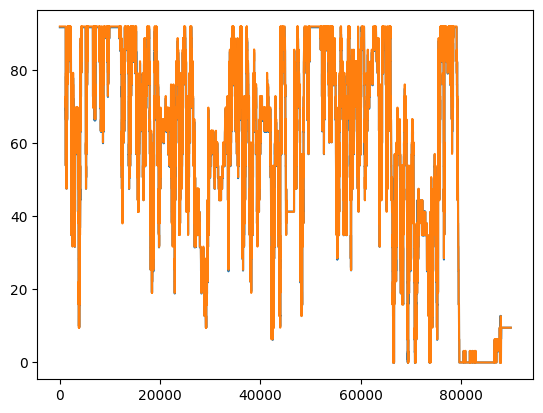

In [85]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [86]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

313/313 [==============================] - 1s 3ms/step


,Val Predictions,Actuals
0,9.518271,9.517241
1,9.518271,9.517241
2,9.518271,9.517241
3,9.518271,9.517241
4,9.518271,9.517241
...,...,...
9995,9.518271,9.517241
9996,9.518271,9.517241
9997,9.518271,9.517241
9998,9.518271,9.517241


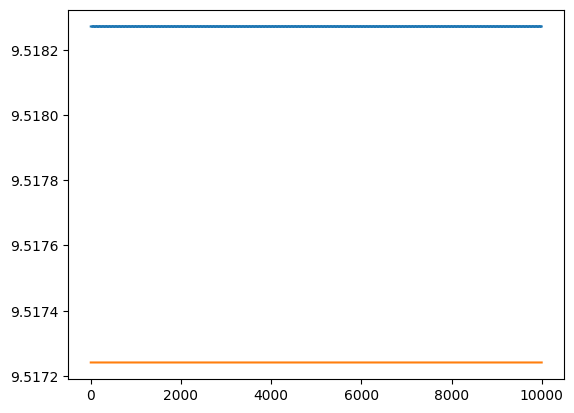

In [87]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [88]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

223/223 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,9.518271,9.517241
1,9.518271,9.517241
2,9.518271,9.517241
3,9.518271,9.517241
4,9.518271,9.517241
...,...,...
7108,9.518272,9.517241
7109,9.518272,9.517241
7110,9.518270,9.517241
7111,9.518270,9.517241


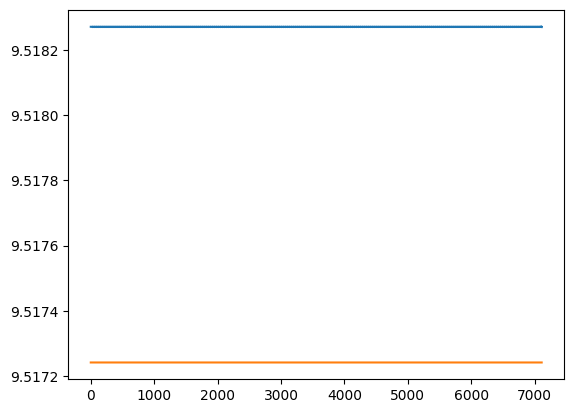

In [90]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

In [116]:
# Vorhersage für den nächsten Punkt nach den Testdaten
next_prediction = model1.predict(X_test1[-1].reshape(1, WINDOW_SIZE, 1))[0][0]

print("Vorhergesagter Wert für den nächsten Punkt:", next_prediction)

1/1 [==============================] - 0s 64ms/step
Vorhergesagter Wert für den nächsten Punkt: 9.518271


In [ ]:
predicted_points = []

# Initialzustand für die Vorhersage: letzter Punkt aus den Testdaten
initial_input_data = X_test1[-1]

for _ in range(5000):  # Vorhersage für die nächsten 100 Punkte
    next_prediction = model1.predict(initial_input_data.reshape(1, WINDOW_SIZE, 1))[0][0]
    predicted_points.append(next_prediction)
    initial_input_data = np.roll(initial_input_data, -1)
    initial_input_data[-1] = next_prediction

1/1 [==============================] - 0s 31ms/step


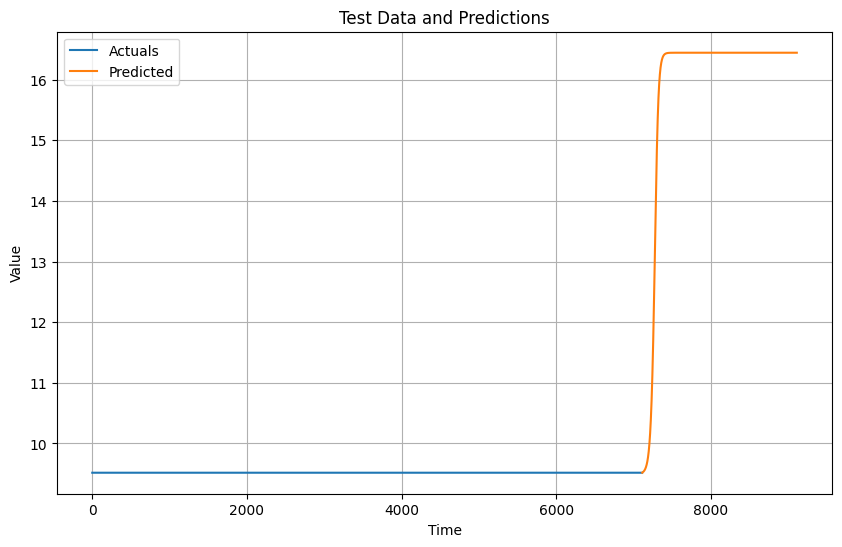

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test1)), y_test1, label='Actuals')
plt.plot(np.arange(len(y_test1), len(y_test1) + len(predicted_points)), predicted_points, label='Predicted')
plt.title('Test Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
initial_input_data.shape

(5, 5, 1)